In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
os.environ['HF_HOME'] = os.environ['TRANSFORMERS_CACHE'] = os.environ['PYTORCH_TRANSFORMERS_CACHE'] = f'{os.environ["WORK"]}/hfcache'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

def PLOG(msg, attr='yellow'):
    print(_c(f'\n<<{"-"*(50-(len(msg)+1)//2)} {msg} {"-"*(50-len(msg)//2)}>>', attr=attr), flush=True)

In [2]:
from nns import exact_search
from resources import _c, printacc, read_sparse_mat, get_text, _filter, XCMetrics
from dl_base import ToD, PreTokBertDataset, XCCollator, cluster_dense_embs, TransformerInputLayer, FixedDataset

import json, socket, sys, os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import scipy.sparse as sp
import xclib.data.data_utils as data_utils
import xclib.evaluation.xc_metrics as xc_metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import AutoModel, AutoTokenizer
transformers.set_seed(42)

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [3]:
command = "--dataset EURLex-4K --maxlen 32 --bsz 52 --lr 1e-4 --n-epochs 100 --device cuda:1"

import argparse, socket
parser = argparse.ArgumentParser()
parser.add_argument('--project', default='Seq2Seq-ipynb')
parser.add_argument('--dataset', default='EURLex-4K')
parser.add_argument('--tf', default='distilbert-base-uncased')
parser.add_argument('--dropout', type=float, default=0.5)
parser.add_argument('--lr', type=float, default=5e-5)
parser.add_argument('--warmup', type=float, default=0.1, help='warmup steps percentage')
parser.add_argument('--bsz', type=int, default=128)
parser.add_argument('--n-epochs', type=int, default=50)
parser.add_argument('--eval-interval', type=int, default=10)
parser.add_argument('--maxlen', type=int, default=32, help='max seq length for transformer')
parser.add_argument('--device', type=str, default='cuda:0')
parser.add_argument('--no-save', action='store_true', help='dont save model and score mat', default=False)

args = parser.parse_args(command.split())
PLOG(f'{args.project} {command}', 'green')

args.hostname = socket.gethostname()
if args.tf.lower() == 'none': args.tf = None
args.expname = f"seq2seq_maxlen-{args.maxlen}_lr-{args.lr}_bsz-{args.bsz}_ep-{args.n_epochs}"

DATA_DIR = f'Datasets/{args.dataset}'
OUT_DIR = f'Results/{args.project}/{args.dataset}/{args.expname}'
os.makedirs(OUT_DIR, exist_ok=True)
print(f'expname: {_c(args.expname, attr="blue")}, dataset: {_c(args.dataset, attr="blue")}')


<<-- Seq2Seq-ipynb --dataset EURLex-4K --maxlen 32 --bsz 52 --lr 1e-4 --n-epochs 100 --device cuda:1 --->>
expname: seq2seq_maxlen-32_lr-0.0001_bsz-52_ep-100, dataset: EURLex-4K


In [4]:
Y = [x.strip() for x in open(f'{DATA_DIR}/raw/Y.txt').readlines()]
trnX = [x.strip() for x in open(f'{DATA_DIR}/raw/trn_X.txt').readlines()]
tstX = [x.strip() for x in open(f'{DATA_DIR}/raw/tst_X.txt').readlines()]

trn_X_Y = read_sparse_mat(f'{DATA_DIR}/trn_X_Y.txt')
tst_X_Y = read_sparse_mat(f'{DATA_DIR}/tst_X_Y.txt')

# trn_X_Xf = normalize(read_sparse_mat(f'{DATA_DIR}/trn_X_Xf.txt'), axis=1)
# tst_X_Xf = normalize(read_sparse_mat(f'{DATA_DIR}/tst_X_Xf.txt'), axis=1)

# xfs = [x.strip() for x in open(f'{DATA_DIR}/Xf.txt', 'r').readlines()]

if "Amazon" in args.dataset: A = 0.6; B = 2.6
elif "WikiSeeAlso" in args.dataset: A = 0.55; B = 1.5
elif "Wiki" in args.dataset: A = 0.5; B = 0.4
else : A = 0.55; B = 1.5
inv_prop = xc_metrics.compute_inv_propesity(trn_X_Y, A, B)

tst_filter_mat = None
if os.path.exists('%s/tst_filter_labels.txt'%(DATA_DIR)):
    temp = np.fromfile('%s/tst_filter_labels.txt'%(DATA_DIR), sep=' ').astype(int)
    temp = temp.reshape(-1, 2).T
    tst_filter_mat = sp.coo_matrix((np.ones(temp.shape[1]), (temp[0], temp[1])), tst_X_Y.shape).tocsr()

invY = {v: k for k, v in enumerate(Y)}

/home1/08343/nilesh/.local/lib/python3.7/site-packages/xclib-0.97-py3.7-linux-x86_64.egg/xclib/data/data_utils.py:263: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")


In [5]:
from tokenizers import normalizers, pre_tokenizers
from tokenizers.normalizers import Lowercase, NFD, StripAccents
from tokenizers.pre_tokenizers import Whitespace, Punctuation
from tokenizers.processors import TemplateProcessing
from tokenizers.trainers import WordPieceTrainer, BpeTrainer
from tokenizers import Tokenizer
from tokenizers.models import WordPiece, BPE

label_tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

label_tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase(), StripAccents()])

label_tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Punctuation()])

label_tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A [SEP]",
    pair="[CLS] $A [SEP] $B:1 [SEP]:1",
    special_tokens=[
        ("[CLS]", 1),
        ("[SEP]", 2),
    ],
)

trainer = BpeTrainer(vocab_size=4000, special_tokens=["[PAD]", "[CLS]", "[SEP]", "[UNK]", "[MASK]"]
)

In [6]:
label_tokenizer.train_from_iterator(Y, trainer)
label_tokenizer.save(f'{OUT_DIR}/label_tokenizer.pt')

label_tokens = label_tokenizer.encode_batch(Y)
Y_ii = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(x.ids) for x in label_tokens], batch_first=True, padding_value=label_tokenizer.token_to_id('[PAD]'))
Y_am = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(x.attention_mask) for x in label_tokens], batch_first=True)

In [7]:
args.token_type = 'bert-base-uncased'
if 'roberta' in args.tf: args.token_type = 'roberta-base'
trn_dataset = PreTokBertDataset(f'{DATA_DIR}/{args.token_type}-{args.maxlen}', trn_X_Y, args.maxlen, doc_type='trn')
tst_dataset = PreTokBertDataset(f'{DATA_DIR}/{args.token_type}-{args.maxlen}', tst_X_Y, args.maxlen, doc_type='tst')

In [8]:
trn_dataset.Y_ii = Y_ii
trn_dataset.Y_am = Y_am

tst_dataset.Y_ii = Y_ii
tst_dataset.Y_am = Y_am

In [9]:
label_pad_id = label_tokenizer.token_to_id('[PAD]')
label_start_id = label_tokenizer.token_to_id('[CLS]')
label_vocab_size = label_tokenizer.get_vocab_size()

from genre_trie import *
trie = MarisaTrie(trn_dataset.get_fts(np.arange(len(Y)), source='label')['input_ids'], cache_fist_branch=False)

def get_target_mask(xind, yind, y):
    positives = trn_X_Y[xind].indices
    Y_positives = Y_ii[positives].numpy()
    trie_mask = torch.zeros(len(y), label_vocab_size).bool()
    target_mask = torch.ones(len(y), label_vocab_size).bool()
    for i in range(len(y)):
        candidates = np.array(trie.get(y[:i]))
        trie_mask[i, candidates] = True
        trie_mask[i, Y_positives[:, i]] = False
        trie_mask[i, y[i]] = True
        
        target_mask[i, np.intersect1d(Y_positives[:, i], candidates)] = False
        target_mask[i, y[i]] = True
    return trie_mask, target_mask

In [10]:
from dl_base import csr_to_pad_tensor

In [11]:
temp = trn_X_Y.tocoo()
trn_tuples = np.array(list(zip(temp.row, temp.col)))
trn_tst_tuples = np.hstack((np.arange(trn_X_Y.shape[0]).reshape(-1, 1), np.zeros((trn_X_Y.shape[0], 1)).astype(int)))
tst_tuples = np.hstack((np.arange(tst_X_Y.shape[0]).reshape(-1, 1), np.zeros((tst_X_Y.shape[0], 1)).astype(int)))

class Seq2SeqTrnCollator():
    def __init__(self, dataset):
        self.numy = dataset.labels.shape[1]
        self.dataset = dataset
    
    def __call__(self, ids):
        ids = torch.LongTensor(ids)
        batch_size = len(ids)        
        batch_data = {'batch_size': torch.LongTensor([batch_size]),
                      'ids': ids,
                      'xfts': self.dataset.get_fts(ids[:, 0], 'point'),
                      'yfts': self.dataset.get_fts(ids[:, 1], 'label'),
                     }
        batch_data['target_mask'] = torch.zeros(batch_size, batch_data['yfts']['input_ids'].shape[1], label_vocab_size).bool()
        batch_data['trie_mask'] = torch.zeros(batch_size, batch_data['yfts']['input_ids'].shape[1], label_vocab_size).bool()
        for i in range(batch_size):
            temp = get_target_mask(ids[i, 0], ids[i, 1], batch_data['yfts']['input_ids'][i])
            batch_data['trie_mask'][i] = temp[0]
            batch_data['target_mask'][i] = temp[1]
            
        return batch_data
    
class LabelWiseSeq2SeqTrnCollator():
    def __init__(self, dataset):
        self.numy = dataset.labels.shape[1]
        self.dataset = dataset
        self.Y_X = dataset.labels.T.tocsr()
    
    def __call__(self, label_ids):
        batch_size = len(label_ids)
        label_ids = torch.LongTensor(label_ids)
        label_positives = csr_to_pad_tensor(self.Y_X[label_ids], self.Y_X.shape[0]) 
        batch_x_inds = torch.multinomial(label_positives['vals'].double(), 1)
        batch_x = torch.gather(label_positives['inds'], 1, batch_x_inds).squeeze()
        ids = torch.cat([batch_x.unsqueeze(-1), label_ids.unsqueeze(-1)], dim=-1)
        
        batch_data = {'batch_size': torch.LongTensor([batch_size]),
                      'ids': ids,
                      'xfts': self.dataset.get_fts(ids[:, 0], 'point'),
                      'yfts': self.dataset.get_fts(ids[:, 1], 'label'),
                     }
        batch_data['target_mask'] = torch.zeros(batch_size, batch_data['yfts']['input_ids'].shape[1], label_vocab_size).bool()
        batch_data['trie_mask'] = torch.zeros(batch_size, batch_data['yfts']['input_ids'].shape[1], label_vocab_size).bool()
        for i in range(batch_size):
            temp = get_target_mask(ids[i, 0], ids[i, 1], batch_data['yfts']['input_ids'][i])
            batch_data['trie_mask'][i] = temp[0]
            batch_data['target_mask'][i] = temp[1]
            
        return batch_data
    
# trn_collator = Seq2SeqTrnCollator(trn_dataset)
trn_collator = LabelWiseSeq2SeqTrnCollator(trn_dataset)
tst_collator = Seq2SeqTrnCollator(tst_dataset)

In [12]:
# trn_loader = torch.utils.data.DataLoader(
#     trn_tuples,
#     batch_size=args.bsz,
#     num_workers=8,
#     collate_fn=trn_collator,
#     shuffle=True,
#     pin_memory=True)

trn_loader = torch.utils.data.DataLoader(
    np.arange(trn_X_Y.shape[1]),
    batch_size=args.bsz,
    num_workers=8,
    collate_fn=trn_collator,
    shuffle=True,
    pin_memory=True)

tst_loader = torch.utils.data.DataLoader(
    tst_tuples,
    batch_size=args.bsz//2,
    num_workers=8,
    collate_fn=tst_collator,
    shuffle=False,
    pin_memory=True)

trn_tst_loader = torch.utils.data.DataLoader(
    trn_tst_tuples,
    batch_size=args.bsz//2,
    num_workers=4,
    collate_fn=trn_collator,
    shuffle=False,
    pin_memory=True)

In [13]:
# def tensorToLabel(out):
#     return np.array([invY[val.replace(' ', '')] for val in label_tokenizer.decode_batch(out.detach().cpu().numpy())])                                                                                    skip_special_tokens=True)])

def get_trie_candidates(batch_id, x):
    return trie.get(x[1:])

import difflib
def tensorToLabel(out):
    out_str = [val.replace(' ', '') for val in label_tokenizer.decode_batch(out.detach().cpu().numpy())]
    label_ids = []
    for val in out_str:
        if not (val in invY):
            val = difflib.get_close_matches(val, Y, n=1, cutoff=0)[0]
        label_ids.append(invY[val])
    return np.array(label_ids)

def predict(net, tst_loader, K=10):
    data = np.zeros((tst_X_Y.shape[0], K))
    inds = np.zeros((tst_X_Y.shape[0], K)).astype(np.int32)
    indptr = np.arange(0, tst_X_Y.shape[0]*K+1, K)
    net.eval()

    with torch.no_grad():
        for b in tqdm(tst_loader, leave=True, desc='Evaluating'):
            b = ToD(b, args.device)
            with torch.cuda.amp.autocast(True):
                out = net.generate(**b['xfts'], 
                                   num_return_sequences=K, 
                                   num_beams=K, 
                                   output_scores = True, 
                                   return_dict_in_generate=True, 
                                   prefix_allowed_tokens_fn = get_trie_candidates)
            
            label_ids = tensorToLabel(out['sequences'])
            data[b['ids'][:, 0].cpu()] = out['sequences_scores'].reshape(-1, K).detach().cpu().numpy()
            inds[b['ids'][:, 0].cpu()] = label_ids.reshape(-1, K)
            del out

    torch.cuda.empty_cache() 
    score_mat = sp.csr_matrix((data.ravel(), inds.ravel(), indptr), tst_X_Y.shape)
    return score_mat

In [14]:
from transformers import EncoderDecoderModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
net = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased", )
# net = EncoderDecoderModel.from_pretrained(f'Results/Seq2Seq-ipynb/EURLex-4K/seq2seq_lr-2e-05_bsz-32_ep-25/model')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relations

In [15]:
net.decoder.cls.predictions.decoder = nn.Linear(768, label_tokenizer.get_vocab_size())

In [16]:
net.load_state_dict(torch.load(f'Results/Seq2Seq-ipynb/EURLex-4K/seq2seq_maxlen-128_lr-5e-05_bsz-50_ep-50_main-logits/model.pt', map_location='cpu'))

<All keys matched successfully>

## Analysis

In [17]:
seq_score_mat = sp.load_npz(f'Results/Seq2Seq-ipynb/EURLex-4K/seq2seq_maxlen-128_lr-5e-05_bsz-50_ep-50_main-logits/score_mat.npz')

In [18]:
ova_score_mat = sp.load_npz(f'../../../work/JointXRL/Results/Joint-XRL/EURLex-4K/BertDXML-0/score_mat.npz')

In [19]:
def vis_point(x, spmat, X, Y, nnz, true_mat=None, sep='', K=-1, expand=False):
    if K == -1: K = spmat[x].nnz
    if true_mat is None: true_mat = tst_X_Y
        
    sorted_inds = spmat[x].indices[np.argsort(-spmat[x].data)][:K]
    print(f'x[{x}]: {_c(X[x], attr="bold")}\n')
    for i, ind in enumerate(sorted_inds):
        myattr = ""
        if true_mat[x, ind] > 0.1: myattr="yellow"
        print(f'{i+1}) {_c(Y[ind], attr=myattr)} [{ind}] ({"%.4f"%spmat[x, ind]}, {nnz[ind]})')
        if expand:
            for j, trn_ind in enumerate(trn_Y_X[ind].indices[:10]):
                print(f'\t{j+1}) {_c(trnX[trn_ind], attr="green")} [{trn_ind}] ({trnx_nnz[trn_ind]})')
        print(sep)
nnz = trn_X_Y.getnnz(0)

In [38]:
np.random.choice(Y)

'european_legal_area'

In [34]:
from resources import get_sorted_spmat

In [88]:
ova_score_mat = get_sorted_spmat(ova_score_mat)
seq_score_mat = get_sorted_spmat(seq_score_mat)

In [57]:
from xclib.utils.sparse import retain_topk

In [67]:
top5_seq_score_mat = retain_topk(seq_score_mat, copy=True, k=5)
top5_ova_score_mat = retain_topk(ova_score_mat, copy=True, k=5)

In [68]:
seq_intrsxn = (top5_seq_score_mat.multiply(tst_X_Y)).getnnz(1)
ova_intrsxn = (top5_ova_score_mat.multiply(tst_X_Y)).getnnz(1)

In [164]:
seq_labelwise_intrsxn = (top5_seq_score_mat.multiply(tst_X_Y)).getnnz(0)
ova_labelwise_intrsxn = (top5_ova_score_mat.multiply(tst_X_Y)).getnnz(0)

In [203]:
diff = seq_labelwise_intrsxn - ova_labelwise_intrsxn

In [204]:
sorted_inds = np.argsort(diff)

In [210]:
targets = sorted_inds[[-1, -2, -3, -4, -5, 4, 3, 2, 1, 0]]

In [223]:
df = pd.DataFrame({'Our Approach': seq_labelwise_intrsxn[targets], 'Bert-OvA': ova_labelwise_intrsxn[targets]})

df.index = [Y[i] for i in targets]

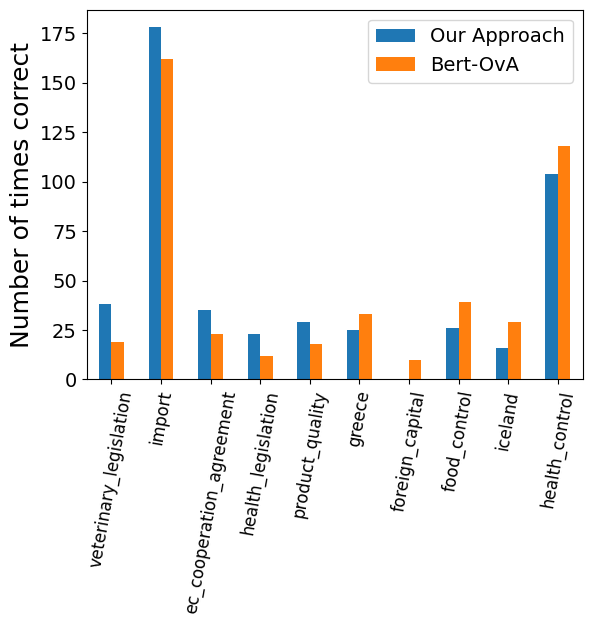

In [233]:
df.plot(kind='bar')
plt.ylabel('Number of times correct', fontsize=18)
plt.xticks(fontsize=12, rotation=80);
plt.yticks(fontsize=14);
plt.legend(prop={'size': 14})
# plt.yscale('log')
plt.savefig(f'easy_hard_labels.pdf', bbox_inches='tight')

In [206]:
diff[sorted_inds[-5:]]

array([11, 11, 12, 16, 19])

In [136]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')

In [139]:
import seaborn as sns

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


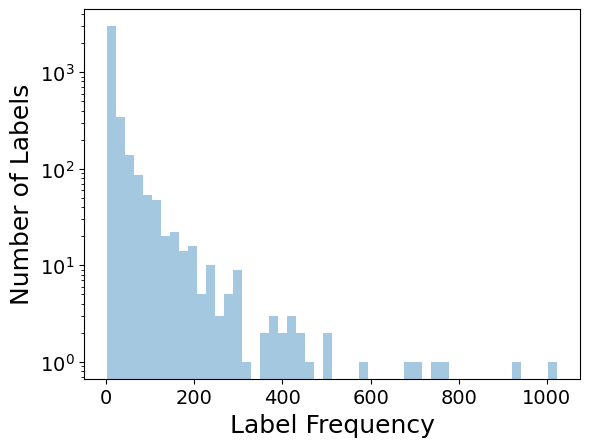

In [149]:
sns.distplot(nnz, kde=False, )
# plt.yscale('log')
plt.xlabel('Label Frequency', fontsize=18)
plt.ylabel('Number of Labels', fontsize=18)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.yscale('log')
plt.savefig(f'label_freq.pdf', bbox_inches='tight')

In [168]:
decile_mask.shape

(10, 3801)

In [169]:
import xclib
def get_decile_mask(X_Y):
    nnz = X_Y.getnnz(0)
    sorted_inds = np.argsort(-nnz)
    cumsum_sorted_nnz = nnz[sorted_inds].cumsum()

    deciles = [sorted_inds[np.where((cumsum_sorted_nnz > i*nnz.sum()/10) & (cumsum_sorted_nnz <= (i+1)*nnz.sum()/10))[0]] for i in range(10)]
    decile_mask = np.zeros((10, trn_X_Y.shape[1]), dtype=np.bool)
    for i in range(10):
        decile_mask[i, deciles[i]] = True
    return decile_mask

def decileWisePVolume(score_mats, K=5, mask=None):
    if mask is None : mask = decile_mask
    plt.xticks(range(decile_mask.shape[0]))
    plt.title('decile contribution to P@%d'%(K))
        
    alldata = []
    for score_mat, name in score_mats:
        temp_score_mat = score_mat.copy()
        temp_score_mat = xclib.utils.sparse.retain_topk(temp_score_mat, k=K)
        intrsxn_score_mat = temp_score_mat.multiply(tst_X_Y)
        
        intrsxn_data = [decile_mask[i, intrsxn_score_mat.indices].sum()*100 / (intrsxn_score_mat.shape[0]*K) for i in range(decile_mask.shape[0])]
        plt.plot(intrsxn_data, label=name)
        plt.legend()
        
        intrsxn_data.append(sum(intrsxn_data))
        alldata.append(intrsxn_data)
        del intrsxn_score_mat, temp_score_mat
        
    df = pd.DataFrame(alldata)
    df.index = [score_mat[1] for score_mat in score_mats]
    df.columns = [*[str(i+1) for i in range(decile_mask.shape[0])], 'P@%d'%K]
    df = df.round(2)
    return df

def decileWiseVolume(score_mats, K=5, mask=None):
    if mask is None : mask = decile_mask
    plt.xticks(range(decile_mask.shape[0]))
    plt.title(f'% deciles present in score_mat top {K}')
    
    alldata = []
    for score_mat, name in score_mats:
        temp_score_mat = score_mat.copy()
        temp_score_mat = xclib.utils.sparse.retain_topk(temp_score_mat, k=K)
        data = [decile_mask[i, temp_score_mat.indices].sum()*100 / temp_score_mat.nnz for i in range(decile_mask.shape[0])]
        plt.plot(data, label=name)
        plt.legend()
        alldata.append(data)
        del temp_score_mat
        
    df = pd.DataFrame(alldata)
    df.index = [score_mat[1] for score_mat in score_mats]
    df.columns = [str(i+1) for i in range(decile_mask.shape[0])]
    df = df.round(2)
    return df

In [151]:
decile_mask = get_decile_mask(trn_X_Y)

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [171]:
Ylen = np.array([len(y.split('_')) for y in Y])

In [177]:
for i in range(Ylen.max()):
    decile_mask[i, :] = (Ylen == i+1)

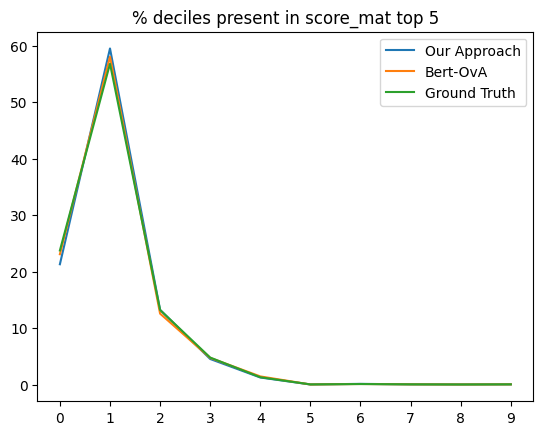

In [200]:
df = decileWiseVolume([(seq_score_mat, 'Our Approach'), (ova_score_mat, 'Bert-OvA'), (tst_X_Y, 'Ground Truth')])

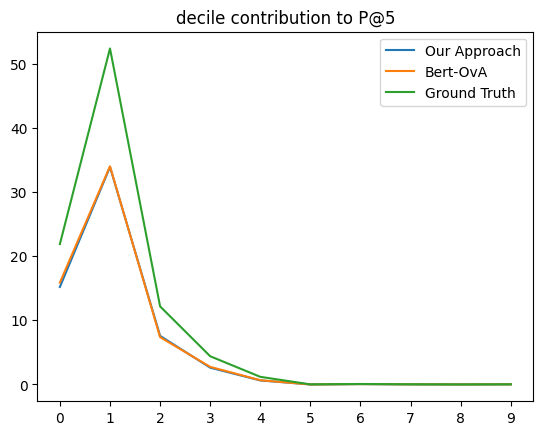

In [198]:
df = decileWisePVolume([(seq_score_mat, 'Our Approach'), (ova_score_mat, 'Bert-OvA'), (tst_X_Y, 'Ground Truth')])

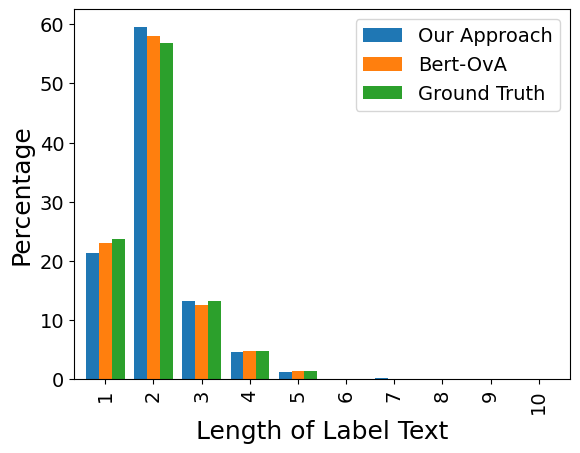

In [201]:
df.T.plot(kind='bar', width=0.8)
plt.xlabel('Length of Label Text', fontsize=18)
plt.ylabel('Percentage', fontsize=18)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.legend(prop={'size': 14})
# plt.yscale('log')
# plt.savefig(f'label_len_volume.pdf', bbox_inches='tight')

In [109]:
targets = np.where(seq_intrsxn - ova_intrsxn < -1)[0]

In [27]:
tst_Y_X = tst_X_Y.T.tocsr()

In [28]:
np.intersect1d(tst_Y_X[1468].indices, tst_Y_X[1669].indices)

array([ 796, 3174], dtype=int32)

In [26]:
invY['fishing_agreement'], invY['guinea-bissau']

(1468, 1669)

In [113]:
# ind = np.random.randint(len(tstX))
# ind = 3174
ind = np.random.choice(targets)
vis_point(ind, seq_score_mat, tstX, Y, nnz, tst_X_Y, sep=' ')

x[18]: agreement form exchang letter european commun cypru adjust regim import european commun orang origin cypru letter commun sir honour refer negoti agricultur cypriot author european commiss impact uruguai round trade relat parti adjust import regim orang cypru foreseen agreement reach put forc advanc provision basi pend entri forc global packag provis import regim orang decemb season tonn orang origin cypru import ec specif duti reduc entri price level respect ecu tonn ecu tonn ecu tonn ecu tonn ecu tonn entri price lot entri price agre paragraph specif duti agre entri price entri price lot agre entri price specif duti bound wto appli agreement enter forc signatur parti applic decemb entri forc global packag oblig confirm govern agreement content letter accept sir assur highest consider council european union gt refer film gt letter cypru sir honour acknowledg receipt letter todai date read honour refer negoti agricultur cypriot author european commiss impact uruguai round trade r

In [112]:
vis_point(ind, ova_score_mat, tstX, Y, nnz, tst_X_Y, sep=' ')

x[1366]: commiss regul ec januari amend commiss regul ec lai measur implement common basic standard aviat secur text eea relev commiss european commun regard treati establish european commun regard regul ec european parliament council decemb establish common rule field civil aviat secur articl thereof commiss requir virtu regul ec adopt measur implement common basic standard aviat secur european union commiss regul ec april lai measur implement common basic standard aviat secur act measur accord regul order prevent unlaw act measur laid annex regul ec secret publish rule necessarili appli amend act harmonis list access public set separ articl prohibit carri passeng restrict area cabin aircraft articl prohibit carri baggag intend stowag aircraft hold recognis list exhaust author permit prohibit articl addit list check phase passeng inform articl prohibit harmonis rule govern staff includ flight crew carri articl prohibit passeng requir enabl perform duti regul ec amend measur provid reg

In [115]:
bs = '\\'
print('Ground Truth &', ', '.join([f'{bs+"rpred" if tst_X_Y[ind, i] > 0.5 else bs+"wpred"}{{{bs}texttt{{{" ".join(Y[i].split("_"))}}}}}' for i in tst_X_Y[ind].indices[:5]]), '\\\\')

print(bs+'midrule')
bs = '\\'
print('Our Approach &', ', '.join([f'{bs+"rpred" if tst_X_Y[ind, i] > 0.5 else bs+"wpred"}{{{bs}texttt{{{" ".join(Y[i].split("_"))}}}}} ({bs}texttt{{{"%.2f"%seq_score_mat[ind, i]}}})' for i in seq_score_mat[ind].indices[:5]]), '\\\\')

print(bs+'midrule')
bs = '\\'
print('Bert-OvA &', ', '.join([f'{bs+"rpred" if tst_X_Y[ind, i] > 0.5 else bs+"wpred"}{{{bs}texttt{{{" ".join(Y[i].split("_"))}}}}} ({bs}texttt{{{"%.2f"%ova_score_mat[ind, i]}}})' for i in ova_score_mat[ind].indices[:5]]), '\\\\')

Ground Truth & \rpred{\texttt{citrus fruit}}, \rpred{\texttt{cyprus}}, \rpred{\texttt{ec trade agreement}}, \rpred{\texttt{import}}, \rpred{\texttt{originating product}} \\
\midrule
Our Approach & \wpred{\texttt{import policy}} (\texttt{-0.10}), \wpred{\texttt{import price}} (\texttt{-0.18}), \rpred{\texttt{cyprus}} (\texttt{-0.28}), \wpred{\texttt{import licence}} (\texttt{-0.30}), \wpred{\texttt{ec agreement}} (\texttt{-0.38}) \\
\midrule
Bert-OvA & \rpred{\texttt{cyprus}} (\texttt{7.12}), \rpred{\texttt{import}} (\texttt{1.17}), \wpred{\texttt{ec agreement}} (\texttt{0.90}), \wpred{\texttt{import policy}} (\texttt{0.88}), \rpred{\texttt{citrus fruit}} (\texttt{-1.83}) \\


In [118]:
label_tokenizer.get_vocab()['foreign']

638

In [134]:
label_tokenizer.decode([1731, 492, 141, 218, 1404, 232])

'student capital policy trade enterprise market'

## Code

In [ ]:
# net.load_state_dict(torch.load('Results/Seq2Seq-ipynb/EURLex-4K/seq2seq_lr-5e-05_bsz-196_ep-25/model.pt'))

In [18]:
net.config.decoder_start_token_id = label_tokenizer.token_to_id('[CLS]')
net.config.eos_token_id = label_tokenizer.token_to_id('[SEP]')
net.config.pad_token_id = label_tokenizer.token_to_id('[PAD]')
net.encoder.config.vocab_size = net.config.encoder.vocab_size
net.decoder.config.vocab_size = label_tokenizer.get_vocab_size()

net.config.max_length = 32
net.config.min_length = 2
net.config.no_repeat_ngram_size = 3
net.config.early_stopping = False
net.config.length_penalty = 1.0
net.config.num_beams = 4

In [19]:
criterion = torch.nn.CrossEntropyLoss()
optims = [transformers.optimization.AdamW(net.parameters(), **{'lr': args.lr, 'eps': 1e-06, 'weight_decay': 0.01})]
total_steps = len(trn_loader)*args.n_epochs
schedulers = [transformers.get_linear_schedule_with_warmup(optim, num_warmup_steps=int(args.warmup*total_steps), num_training_steps=total_steps) for optim in optims]

In [20]:
net.to(args.device)

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [21]:
def predict(net, tst_loader, K=10):
    data = np.zeros((tst_X_Y.shape[0], K))
    inds = np.zeros((tst_X_Y.shape[0], K)).astype(np.int32)
    indptr = np.arange(0, tst_X_Y.shape[0]*K+1, K)
    net.eval()

    with torch.no_grad():
        for b in tqdm(tst_loader, leave=True, desc='Evaluating'):
            b = ToD(b, args.device)
            with torch.cuda.amp.autocast(True):
                out = generate(net, b, K)
            
            label_ids = tensorToLabel(out['sequences'])
            data[b['ids'][:, 0].cpu()] = out['sequences_scores'].reshape(-1, K).detach().cpu().numpy()
            inds[b['ids'][:, 0].cpu()] = label_ids.reshape(-1, K)
            del out

    torch.cuda.empty_cache()
    score_mat = sp.csr_matrix((data.ravel(), inds.ravel(), indptr), tst_X_Y.shape)
    return score_mat

def generate(net, b, K):
    with torch.no_grad():
        encoder_out = net.encoder(**b['xfts'])
        seq_input_ids = torch.full((b['batch_size']*K, 2), label_start_id, device=args.device)
        seq_scores = torch.full((b['batch_size']*K, ), -1e5, device=args.device)
        seq_scores[K*torch.arange(b['batch_size'].item())] = 0
        next_candidates = [trie.get([1])]*(b['batch_size']*K)
        encoder_hidden_states = encoder_out.last_hidden_state.repeat_interleave(K, dim=0)
        encoder_attention_mask = b['xfts']['attention_mask'].repeat_interleave(K, dim=0)
        for _ in range(30):
            decoder_out = net.decoder.forward(input_ids=seq_input_ids, 
                                            encoder_hidden_states=encoder_hidden_states, 
                                            encoder_attention_mask=encoder_attention_mask, 
                                            return_dict=True)
            logits = decoder_out.logits[:, -1, :]
            temp_logits = torch.full_like(logits[0], -1e4)
            for i in range(logits.shape[0]):
                temp_logits[next_candidates[i]] = logits[i, next_candidates[i]]
                logits[i] = temp_logits
                temp_logits[next_candidates[i]] = -1e4
            next_scores = F.logsigmoid(logits) + seq_scores[:, None]
#             next_scores = F.log_softmax(logits, dim=-1) + seq_scores[:, None]
            topk_next_scores, topk_next_inds = next_scores.topk(K, dim=-1)
            topk_next_scores = topk_next_scores.reshape(b['batch_size'], -1)
            topk_next_inds = topk_next_inds.reshape(b['batch_size'], -1)
            topk_next_scores, temp_inds = topk_next_scores.topk(K, dim=-1)
            topk_next_inds = topk_next_inds.gather(-1, temp_inds)

            seq_scores = topk_next_scores.reshape(-1)
            next_tokens = topk_next_inds.reshape(-1)
            next_input_ids = torch.zeros((seq_input_ids.shape[0], seq_input_ids.shape[1]+1), device=args.device).long()
            stop = True
            for i in range(next_tokens.shape[0]):
                sample_id = i//K
                topk_id = i%K
                next_input_ids[i, :-1] = seq_input_ids[sample_id*K + temp_inds[sample_id, topk_id]//K]
                next_input_ids[i, -1] = next_tokens[i]
                temp_candidates = trie.get(next_input_ids[i, 1:])
                next_candidates[i] = temp_candidates if len(temp_candidates) > 0 else [label_pad_id]
                if len(temp_candidates) > 0:
                    stop = False

            if stop: break
            seq_input_ids = next_input_ids
        return {'sequences': seq_input_ids, 'sequences_scores': seq_scores}

In [22]:
args.amp = True

In [23]:
best_ndcg = -1
scaler = torch.cuda.amp.GradScaler()

for epoch in range(args.n_epochs):
    net.train()
    cum_loss = 0; ctr = 0
    for optim in optims: optim.zero_grad()
    t = tqdm(trn_loader, desc='Epoch: 0, Loss: 0.0', leave=True)
          
    for i, b in enumerate(t):       
        for optim in optims: optim.zero_grad()
        # loss = criterion(net, b)
        b = ToD(b, args.device)
        with torch.cuda.amp.autocast(args.amp):
            out = net(**b['xfts'], labels=b['yfts']['input_ids'])
        
        main_logits = torch.where(b['target_mask'], out.logits, torch.full_like(out.logits, -10000.0))
#         trie_logits = torch.where(b['trie_mask'], out.logits, torch.full_like(out.logits, -10000.0))
        targets = torch.zeros_like(main_logits)
        targets.scatter_(-1, b['yfts']['input_ids'].unsqueeze(-1), 1.0)
        main_loss = nn.BCEWithLogitsLoss()(main_logits, targets)
#         main_loss = criterion(main_logits.reshape(-1, label_vocab_size), b['yfts']['input_ids'].reshape(-1))
#         trie_loss = criterion(trie_logits.reshape(-1, label_vocab_size), b['yfts']['input_ids'].reshape(-1))
#         loss = main_loss + args.trie_loss_scale*trie_loss
        loss = main_loss
        
        if args.amp:
            scaler.scale(loss).backward()
            for optim in optims: scaler.step(optim)
            scaler.update()
        else:
            loss.backward()
            for optim in optims: optim.step()
                
        for sch in schedulers: sch.step()
                
        cum_loss += loss.item()
        ctr += 1
        t.set_description('Epoch: %d/%d, Loss: %.4E'%(epoch, args.n_epochs, (cum_loss/ctr)), refresh=True)
    
    print(f'mean loss after epoch {epoch}/{args.n_epochs}: {"%.4E"%(cum_loss/ctr)}', flush=True)
        
    if epoch%args.eval_interval == 0 or epoch == (args.n_epochs-1):
        score_mat = predict(net, tst_loader)
        if tst_filter_mat is not None: 
            _filter(score_mat, tst_filter_mat, copy=False)
        metrics = XCMetrics(score_mat, tst_X_Y, inv_prop, method=args.expname, disp=True)

        if metrics.loc[args.expname]['nDCG@5'] > best_ndcg:
            metrics.to_csv(open(f'{OUT_DIR}/metrics.tsv', 'a'), sep='\t')
            best_ndcg = metrics.loc[args.expname]['nDCG@5']
            print(_c(f'Found new best model with nDCG@5: {"%.2f"%best_ndcg}\n', attr='blue'))

            if not args.no_save:
                sp.save_npz(f'{OUT_DIR}/score_mat.npz', score_mat)
                torch.save(net.state_dict(), f'{OUT_DIR}/model.pt')

Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:490: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more det

mean loss after epoch 0/100: 7.4210E-01


Evaluating:   0%|          | 0/149 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
0.03	0.08	0.03	0.07	0.02	0.1	0.14	0.14	0.14	0.18

Found new best model with nDCG@5: 0.07



Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 1/100: 4.7044E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 2/100: 1.5869E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 3/100: 5.7267E-02


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 4/100: 2.7122E-02


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 5/100: 1.5425E-02


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 6/100: 9.8678E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 7/100: 6.8325E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 8/100: 5.0291E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 9/100: 3.8915E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 10/100: 3.1377E-03


Evaluating:   0%|          | 0/149 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
0.21	0.23	0.21	0.23	0.12	0.23	0.29	0.29	0.29	0.51

Found new best model with nDCG@5: 0.23



Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 11/100: 2.6423E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 12/100: 2.3161E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 13/100: 2.0790E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 14/100: 1.9125E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 15/100: 1.7932E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 16/100: 1.6702E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 17/100: 1.5588E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 18/100: 1.4287E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 19/100: 1.3410E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 20/100: 1.2511E-03


Evaluating:   0%|          | 0/149 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
0.21	0.21	0.21	0.22	0.16	0.23	0.31	0.31	0.31	0.57



Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 21/100: 1.1582E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 22/100: 1.0806E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 23/100: 1.0114E-03


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 24/100: 9.5324E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 25/100: 8.9343E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 26/100: 8.4670E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 27/100: 8.0310E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 28/100: 7.5658E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 29/100: 7.1331E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 30/100: 6.7100E-04


Evaluating:   0%|          | 0/149 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
0.23	0.14	0.23	0.18	0.15	0.15	0.27	0.27	0.27	0.5



Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 31/100: 6.4811E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 32/100: 6.2873E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 33/100: 5.9635E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 34/100: 6.0327E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 35/100: 5.9744E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 36/100: 5.7120E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 37/100: 5.6593E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 38/100: 5.6929E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 39/100: 5.5591E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 40/100: 5.4872E-04


Evaluating:   0%|          | 0/149 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
0.23	0.18	0.23	0.2	0.15	0.2	0.26	0.26	0.26	0.5



Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 41/100: 5.5972E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 42/100: 5.4396E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 43/100: 5.5351E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 44/100: 5.5742E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 45/100: 5.6063E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 46/100: 5.4854E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 47/100: 5.5160E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 48/100: 5.4891E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 49/100: 5.6103E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 50/100: 5.4683E-04


Evaluating:   0%|          | 0/149 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
0.23	0.23	0.23	0.24	0.15	0.24	0.27	0.27	0.27	0.58

Found new best model with nDCG@5: 0.24



Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 51/100: 5.4691E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 52/100: 5.4778E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 53/100: 5.4539E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 54/100: 5.4823E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 55/100: 5.3780E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 56/100: 5.3332E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 57/100: 5.2643E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

mean loss after epoch 58/100: 5.3509E-04


Epoch: 0, Loss: 0.0:   0%|          | 0/74 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [47]:
score_mat = predict(net, tst_loader)
XCMetrics(score_mat, tst_X_Y, inv_prop)

Evaluating:   0%|          | 0/121 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
75.99	53.3	75.99	61.93	39.96	48.03	68.0	68.0	68.0	84.57



,P@1,P@3,P@5,nDCG@1,nDCG@3,nDCG@5,PSP@1,PSP@3,PSP@5,R@10,R@20,R@100,MRR@10
Method,75.99,63.05,53.3,75.99,66.41,61.93,39.96,44.84,48.03,68.0,68.0,68.0,84.57


In [32]:
ok_score_mat = sp.load_npz(f'{OUT_DIR}/score_mat.npz')

In [33]:
print(get_text(1, Y, ok_score_mat))

1 : 
south_korea(-0.17, 3251) shipbuilding(-0.39, 3171) international_market(-0.59, 1916) international_agreement(-0.60, 1899) competition(-0.77, 679) restriction_on_competition(-0.90, 3015) distributive_trades(-1.01, 942) market_access(-1.04, 2176) maritime_transport(-1.17, 2173) market_protection(-1.20, 2184)


In [69]:
Y_ii[tst_X_Y[0].indices]

tensor([[   1,  224,   21,  173,   21, 2511,   21, 3954,    2,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1, 2552,   21,   68,   21,  580,    2,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1, 3826,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1, 1343,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,  232,   21,  751,    2,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [19]:
def generate(net, tst_loader, K=10):
    data = np.zeros((tst_X_Y.shape[0], K))
    inds = np.zeros((tst_X_Y.shape[0], K)).astype(np.int32)
    indptr = np.arange(0, tst_X_Y.shape[0]*K+1, K)
    net.eval()

    with torch.no_grad():
        for b in tqdm(tst_loader, leave=True, desc='Evaluating'):
            b = ToD(b, args.device)
            with torch.cuda.amp.autocast(True):
                out = net.generate(**b['xfts'], 
                                   num_return_sequences=K, 
                                   num_beams=K, 
                                   output_scores = True, 
                                   return_dict_in_generate=True, 
                                   prefix_allowed_tokens_fn = get_trie_candidates)
            
            label_ids = tensorToLabel(out['sequences'])
            data[b['ids'][:, 0].cpu()] = out['sequences_scores'].reshape(-1, K).detach().cpu().numpy()
            inds[b['ids'][:, 0].cpu()] = label_ids.reshape(-1, K)
            del out

In [20]:
args.trie_loss_scale = 0

In [ ]:
best_ndcg = -1
for epoch in range(args.n_epochs):
    net.train()
    cum_loss = 0; ctr = 0
    for optim in optims: optim.zero_grad()
    t = tqdm(trn_loader, desc='Epoch: 0, Loss: 0.0', leave=True)
          
    for i, b in enumerate(t):        
        # loss = criterion(net, b)
        b = ToD(b, args.device)
        out = net(**b['xfts'], labels=b['yfts']['input_ids'])
        
#         main_logits = torch.where(b['target_mask'], out.logits, torch.full_like(out.logits, -10000.0))
#         trie_logits = torch.where(b['trie_mask'], out.logits, torch.full_like(out.logits, -10000.0))
#         main_loss = criterion(main_logits.reshape(-1, label_vocab_size), b['yfts']['input_ids'].reshape(-1))
#         trie_loss = criterion(trie_logits.reshape(-1, label_vocab_size), b['yfts']['input_ids'].reshape(-1))
#         loss = main_loss + args.trie_loss_scale*trie_loss
        loss = out.loss
        loss.backward()
        
        for optim in optims: optim.step()
        for sch in schedulers: sch.step()
        for optim in optims: optim.zero_grad()
                
        cum_loss += loss.item()
        ctr += 1
        t.set_description('Epoch: %d/%d, Loss: %.4E'%(epoch, args.n_epochs, (cum_loss/ctr)), refresh=True)
    
    print(f'mean loss after epoch {epoch}/{args.n_epochs}: {"%.4E"%(cum_loss/ctr)}', flush=True)
        
    if epoch%args.eval_interval == 0 or epoch == (args.n_epochs-1):
        score_mat = predict(net, tst_loader)
        if tst_filter_mat is not None: 
            _filter(score_mat, tst_filter_mat, copy=False)
        metrics = XCMetrics(score_mat, tst_X_Y, inv_prop, method=args.expname, disp=True)

        if metrics.loc[args.expname]['nDCG@5'] > best_ndcg:
            metrics.to_csv(open(f'{OUT_DIR}/metrics.tsv', 'a'), sep='\t')
            best_ndcg = metrics.loc[args.expname]['nDCG@5']
            print(_c(f'Found new best model with nDCG@5: {"%.2f"%best_ndcg}\n', attr='blue'))

            if not args.no_save:
                sp.save_npz(f'{OUT_DIR}/score_mat.npz', score_mat)
                torch.save(net.state_dict(), f'{OUT_DIR}/model.pt')

Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 0/50: 2.4123E+00


Evaluating:   0%|          | 0/121 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
9.94	5.27	9.94	6.52	3.01	2.93	7.21	7.21	7.21	16.15

Found new best model with nDCG@5: 6.52



Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 1/50: 1.0530E+00


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 2/50: 6.5055E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 3/50: 5.0372E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 4/50: 4.4551E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 5/50: 3.9722E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 6/50: 3.6334E-01


Evaluating:   0%|          | 0/121 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
65.9	45.8	65.9	53.24	32.38	38.67	61.79	61.79	61.79	78.0

Found new best model with nDCG@5: 53.24



Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 7/50: 3.4159E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 8/50: 3.2293E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 9/50: 3.0928E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 10/50: 2.9381E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 11/50: 2.8530E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 12/50: 2.7610E-01


Evaluating:   0%|          | 0/121 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
68.87	49.86	68.87	57.28	35.79	44.23	67.78	67.78	67.78	80.13

Found new best model with nDCG@5: 57.28



Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 13/50: 2.6787E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 14/50: 2.6149E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 15/50: 2.5633E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 16/50: 2.5091E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 17/50: 2.4736E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 18/50: 2.4179E-01


Evaluating:   0%|          | 0/121 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
71.0	52.61	71.0	60.14	36.88	46.73	70.04	70.04	70.04	81.59

Found new best model with nDCG@5: 60.14



Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 19/50: 2.3834E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 20/50: 2.3515E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 21/50: 2.3215E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 22/50: 2.2756E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 23/50: 2.2648E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 24/50: 2.2424E-01


Evaluating:   0%|          | 0/121 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
71.95	52.9	71.95	60.71	37.94	47.38	70.08	70.08	70.08	82.28

Found new best model with nDCG@5: 60.71



Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 25/50: 2.2010E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 26/50: 2.1913E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 27/50: 2.1621E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 28/50: 2.1476E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 29/50: 2.1172E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 30/50: 2.1041E-01


Evaluating:   0%|          | 0/121 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
73.84	54.7	73.84	62.57	39.14	49.44	72.07	72.07	72.07	83.42

Found new best model with nDCG@5: 62.57



Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 31/50: 2.0761E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 32/50: 2.0531E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 33/50: 2.0355E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 34/50: 2.0171E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 35/50: 1.9979E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 36/50: 1.9770E-01


Evaluating:   0%|          | 0/121 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
73.69	55.37	73.69	63.21	38.92	49.86	72.3	72.3	72.3	83.52

Found new best model with nDCG@5: 63.21



Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 37/50: 1.9585E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 38/50: 1.9438E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 39/50: 1.9251E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 40/50: 1.9059E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 41/50: 1.8901E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 42/50: 1.8662E-01


Evaluating:   0%|          | 0/121 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
74.95	56.34	74.95	64.3	39.54	50.93	72.74	72.74	72.74	84.26

Found new best model with nDCG@5: 64.30



Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 43/50: 1.8512E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 44/50: 1.8380E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

mean loss after epoch 45/50: 1.8134E-01


Epoch: 0, Loss: 0.0:   0%|          | 0/1286 [00:00<?, ?it/s]

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

In [ ]:
with torch.no_grad()

In [28]:
torch.save(net.state_dict(), f'{OUT_DIR}/model-last.pt')

In [17]:
net.load_state_dict(torch.load('Results/Seq2Seq-ipynb/EURLex-4K/seq2seq_maxlen-256_lr-5e-05_bsz-80_ep-100/model-last.pt'))

<All keys matched successfully>

In [17]:
net.save_pretrained(f'{OUT_DIR}/model')

In [28]:
for b in trn_loader:
    b = ToD(b, args.device)
    break

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [106]:
b = ToD(b, args.device)

In [19]:
net.to(args.device);

In [23]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [22]:
score_mat = predict(net, tst_loader)

Evaluating:   0%|          | 0/121 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/work2/08343/nilesh/maverick2/anaconda3/envs/xc/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single 

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

In [ ]:
score_mat = predict(net, trn_tst_loader)

In [24]:
XCMetrics(score_mat, tst_X_Y, inv_prop, method=args.expname, disp=True);

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
74.95	56.33	74.95	64.3	39.51	50.94	72.76	72.76	72.76	84.26



In [18]:
trn_score_mat = predict(net, trn_loader)

Evaluating:   0%|          | 0/1029 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking arugment for argument index in method wrapper_index_select)

In [29]:
b

{'batch_size': tensor([80], device='cuda:0'),
 'ids': tensor([[14897,  1777],
         [ 1501,  3593],
         [ 4767,  1479],
         [12105,  2599],
         [11950,  1332],
         [ 2057,  3672],
         [12619,  3795],
         [ 1091,  2790],
         [ 6796,  1613],
         [ 9495,  2535],
         [12409,  1247],
         [ 9073,  3113],
         [ 9567,   840],
         [ 8455,   659],
         [11898,  1696],
         [14054,  3747],
         [ 2240,  2148],
         [10099,   191],
         [ 5825,  2081],
         [ 2905,   942],
         [11732,   489],
         [13707,   490],
         [12533,   843],
         [ 7875,  3387],
         [   92,  1924],
         [ 4135,   321],
         [ 5862,   855],
         [ 6019,  2912],
         [ 3453,  1215],
         [ 5154,  2445],
         [ 1470,  1215],
         [ 9892,  1777],
         [ 6177,  2362],
         [ 4020,  2150],
         [ 4605,  1780],
         [11919,  3685],
         [12704,  2102],
         [11019,  1415

In [30]:
with torch.no_grad():
    out = net(**b['xfts'], labels=b['yfts']['input_ids'])

/opt/conda/lib/python3.7/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:490: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


In [32]:
out.logits.argmax(dim=-1)

tensor([[ 353,  353,  570,  570,  570,  570,  570,  570,  570,  570,  570],
        [2217,  941,  941,  941,  884,  884,  884,  884,  884,  884,  884],
        [2396, 2396, 2396, 2396, 2396, 2396, 2396, 2396, 2396, 2396, 2396],
        [1610, 1610, 1291, 1291, 1291, 1291, 1291, 1291, 1291, 1291, 1291],
        [ 165, 1001, 1001,  722,  722,  722,  722,  722,  722,  722,  722],
        [ 488,  488,  148,  148,  297,  297,  297,  297,  297,  297,  297],
        [ 924,  817, 2395, 2395, 2395, 2395, 2395, 2395, 2395, 2395, 2395],
        [ 152,  152,  546,  546,  546,  546,  546,  546,  546,  546,  546],
        [1109, 1109, 2654, 2654, 1109, 1109, 1109, 1109, 1109, 1109, 1109],
        [1421, 1421,   65,   65,   65,   65,   65,   65,   65,   65,   65],
        [ 152,  152, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165],
        [ 737,  737, 1549, 1549,  737,  737,  737,  737,  737,  737,  737],
        [ 570,  570,  570,  570,  570,  570,  570,  570,  570,  570,  570],
        [380

In [42]:
clf_score_mat = sp.load_npz(f'/home/devvrit_03/XC/JointXRL/Results/Joint-XRL/EURLex-4K/BertDXML-0/score_mat.npz')

In [26]:
def vis_point(x, spmat, X, Y, nnz, true_mat=None, sep='', K=-1, expand=False):
    if K == -1: K = spmat[x].nnz
    if true_mat is None: true_mat = tst_X_Y
        
    sorted_inds = spmat[x].indices[np.argsort(-spmat[x].data)][:K]
    print(f'x[{x}]: {_c(X[x], attr="bold")}\n')
    for i, ind in enumerate(sorted_inds):
        myattr = ""
        if true_mat[x, ind] > 0.1: myattr="yellow"
        print(f'{i+1}) {_c(Y[ind], attr=myattr)} [{ind}] ({"%.4f"%spmat[x, ind]}, {nnz[ind]})')
        if expand:
            for j, trn_ind in enumerate(trn_Y_X[ind].indices[:10]):
                print(f'\t{j+1}) {_c(trnX[trn_ind], attr="green")} [{trn_ind}] ({trnx_nnz[trn_ind]})')
        print(sep)
nnz = trn_X_Y.getnnz(0)

In [27]:
# ind = np.random.randint(len(tstX))
ind = 0
vis_point(ind, score_mat, tstX, Y, nnz, tst_X_Y)

x[0]: commiss decis juli lai detail rule applic franc articl regul ec special market support measur beef sector notifi document number french text authent ec commiss european commun regard treati establish european commun regard council regul ec common organis market beef veal articl thereof regard commiss regul ec april special market support measur beef sector articl thereof articl regul ec releas approv commiss meat bought regul laid releas specif commun made avoid disturb market direct competit dispos intervent product applic articl indent subparagraph articl regul ec franc bought quantiti beef franc continu bui meat partial tender end year franc submit request commiss releas tonn beef bought scheme intend distribut depriv person franc meet elig criteria appli commiss regul eec octob lai detail rule suppli food intervent stock benefit depriv person commun amend regul ec request approv releas follow procedur laid indent articl regul eec releas direct consumpt depriv person disturb m

In [41]:
vis_point(ind, tst_X_Y, tstX, Y, nnz, score_mat.astype(bool))

x[3507]: decis eea joint committe novemb amend annex ii technic regul standard test certif eea agreement eea joint committe regard agreement european econom area amend protocol adjust agreement european econom area hereinaft refer quot agreement quot articl thereof annex ii agreement amend decis eea joint committe juli commiss direct ec januari amend annex ii council direct eec fix maximum level pesticid residu product plant origin includ fruit veget incorpor agreement commiss regul ec februari amend regul ec set maximum level contamin foodstuff incorpor agreement commiss decis ec januari amend commiss decis ec regist flavour substanc foodstuff incorpor agreement commiss direct ec februari amend annex council direct eec eec eec fix maximum level pesticid residu cereal foodstuff anim origin product plant origin includ fruit veget incorpor agreement decid articl chapter xii annex ii agreement amend indent ad point council direct eec council direct eec council direct eec quot commiss dire

In [43]:
vis_point(ind, clf_score_mat, tstX, Y, nnz, tst_X_Y, K=10)

x[3507]: decis eea joint committe novemb amend annex ii technic regul standard test certif eea agreement eea joint committe regard agreement european econom area amend protocol adjust agreement european econom area hereinaft refer quot agreement quot articl thereof annex ii agreement amend decis eea joint committe juli commiss direct ec januari amend annex ii council direct eec fix maximum level pesticid residu product plant origin includ fruit veget incorpor agreement commiss regul ec februari amend regul ec set maximum level contamin foodstuff incorpor agreement commiss decis ec januari amend commiss decis ec regist flavour substanc foodstuff incorpor agreement commiss direct ec februari amend annex council direct eec eec eec fix maximum level pesticid residu cereal foodstuff anim origin product plant origin includ fruit veget incorpor agreement decid articl chapter xii annex ii agreement amend indent ad point council direct eec council direct eec council direct eec quot commiss dire

In [50]:
with torch.no_grad():
    out = net.generate(**b['xfts'], 
                       num_return_sequences=10, 
                       num_beams=10, 
                       output_scores = True, 
                       return_dict_in_generate=True, 
                       prefix_allowed_tokens_fn = get_trie_candidates, )

7 tensor([   1,    1, 2264], device='cuda:0') -> [2, 21]
7 tensor([   1,    1, 2264,   21], device='cuda:0') -> [68]
7 tensor([   1,    1, 2264,   21,   68], device='cuda:0') -> [21]
7 tensor([   1,    1, 2264,   21,   68,   21], device='cuda:0') -> [1117]
7 tensor([   1,    1, 2264,   21,   68,   21, 1117], device='cuda:0') -> [2]
7 tensor([   1,    1, 2264,   21,   68,   21,   18], device='cuda:0') -> []
7 tensor([   1,    1, 2264,   21,   68,   21,   15], device='cuda:0') -> []
7 tensor([   1,    1, 2264,   21,   68,   21,   17], device='cuda:0') -> []
7 tensor([   1,    1, 2264,   21,   68,   21,    1], device='cuda:0') -> []
7 tensor([   1,    1, 2264,   21,   68,   21,    0], device='cuda:0') -> []
7 tensor([   1,    1, 2264,   21,   68,   21,   16], device='cuda:0') -> []
7 tensor([   1,    1, 2264,   21,   68,   21,   12], device='cuda:0') -> []
7 tensor([   1,    1, 2264,   21,   68,   21,    9], device='cuda:0') -> []
7 tensor([   1,    1, 2264,   21,   68,   21,    7], devic

In [53]:
preds = label_tokenizer.decode_batch(out['sequences'].cpu().detach().numpy())

In [48]:
get_trie_candidates(0, [   1,    1, 2264,   21,   68,   21, 1117])

0 [1, 1, 2264, 21, 68, 21, 1117] -> [2]


[2]

In [55]:
out['sequences'][72]

tensor([   1,    1, 2264,   21,   68,   21, 1117,    2,    0,    0,    0,    0,
           0], device='cuda:0')

In [54]:
[(i, y) for i, y in enumerate(preds)]

[(0, 'france'),
 (1, 'production _ aid'),
 (2, 'beef'),
 (3, 'aid _ to _ agriculture'),
 (4, 'suck ler _ cow'),
 (5, 'state _ aid'),
 (6, 'aid _ system'),
 (7, 'production _ quota'),
 (8, 'agricultural _ guidance'),
 (9, 'community _ aid'),
 (10, 'market _ stabilisation'),
 (11, 'south _ korea'),
 (12, 'public _ sector'),
 (13, 'market _ access'),
 (14, 'market _ protection'),
 (15, 'public _ contract'),
 (16, 'public _ service'),
 (17, 'market _ supervision'),
 (18, 'market _ prices'),
 (19, 'international _ trade'),
 (20, 'fishery _ product'),
 (21, 'export _ refund'),
 (22, 'export _ licence'),
 (23, 'preserve d _ product'),
 (24, 'third _ country'),
 (25, 'import _ policy'),
 (26, 'community _ import'),
 (27, 'import _ licence'),
 (28, 'agricultural _ product'),
 (29, 'customs _ regulations'),
 (30, 'import _ licence'),
 (31, 'origin ating _ product'),
 (32, 'tariff _ quota'),
 (33, 'beef'),
 (34, 'meat _ product'),
 (35, 'live _ animal'),
 (36, 'bul garia'),
 (37, 'bul b _ vegetab

In [54]:
XCMetrics(score_mat, tst_X_Y, inv_prop)

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
72.52	48.75	72.52	57.19	37.91	44.27	59.68	61.87	62.04	76.89



,P@1,P@3,P@5,nDCG@1,nDCG@3,nDCG@5,PSP@1,PSP@3,PSP@5,R@10,R@20,R@100,MRR@10
Method,72.52,59.31,48.75,72.52,62.72,57.19,37.91,42.27,44.27,59.68,61.87,62.04,76.89


In [43]:
K = 5
out = net.generate( **trn_dataset.get_fts([0]), 
                    num_return_sequences=K, 
                    num_beams=K, 
                    output_scores = True, 
                    return_dict_in_generate=True, 
                    prefix_allowed_tokens_fn = get_trie_candidates)

In [25]:
XCMetrics(score_mat, tst_X_Y, inv_prop)

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
89.21	59.92	89.21	70.22	50.03	56.32	72.84	74.71	74.76	89.41



,P@1,P@3,P@5,nDCG@1,nDCG@3,nDCG@5,PSP@1,PSP@3,PSP@5,R@10,R@20,R@100,MRR@10
Method,89.21,74.63,59.92,89.21,78.38,70.22,50.03,55.58,56.32,72.84,74.71,74.76,89.41


In [153]:
net.to(args.device);

In [150]:
for b in trn_loader:
    b = ToD(b, args.device)
    break

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [157]:
out = net(**b['xfts'], labels=b['yfts']['input_ids'])

In [24]:
out.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'encoder_last_hidden_state'])

In [159]:
out['logits'].shape

torch.Size([4, 7, 4000])

In [23]:
tokenizer.batch_decode(b['yfts']['input_ids'])

['[CLS] right _ of _ establishment [SEP] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] market _ approval [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] norway [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] protocol _ to _ an _ agreement [SEP] [PAD] [PAD]',
 '[CLS] switzerland [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] fodder _ plant [SEP] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] derogation _ from _ community _ law [SEP]',
 '[CLS] vehicle _ parts [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] poultry [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] control _ of _ state _ aid [SEP] [PAD] [PAD]',
 '[CLS] free _ circulation [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] aid _ to _ undertakings [SEP] [PAD] [PAD] [PAD]',
 '[CLS] quality _ standard [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] waste _ management [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] care _ of _ mothers _ and _ infants [SEP]',
 '[CLS] marketing _ standard [SE

In [55]:
for i in b['ids']:
#     print(f'\n{tstX[i[0]][:80]}')
    print(get_text(i[0].cpu().item(), Y, trn_X_Y))

0 : 
action_programme(1.00, 47) child_protection(1.00, 522) community_financing(1.00, 630) information_policy(1.00, 1840) internet(1.00, 1932) public_awareness_campaign(1.00, 2852)
1 : 
cereals(1.00, 490) marketing_standard(1.00, 2191) seed(1.00, 3128)
2 : 
cereals(1.00, 490) production_refund(1.00, 2800) rice(1.00, 3030) starch(1.00, 3290)
3 : 
approximation_of_laws(1.00, 223) carrying_capacity(1.00, 461) community_certification(1.00, 619) measuring_equipment(1.00, 2209) tanker(1.00, 3384)
4 : 
bulgaria(1.00, 402) ec_interim_agreement(1.00, 1038) ec_trade_agreement(1.00, 1060) ecsc(1.00, 1110) protocol_to_an_agreement(1.00, 2838)
5 : 
commonwealth(1.00, 606) conservation_of_fish_stocks(1.00, 709) dominica(1.00, 957) fishing_agreement(1.00, 1468) fishing_licence(1.00, 1474) fishing_vessel(1.00, 1481)
6 : 
import(1.00, 1777) import_licence(1.00, 1780) pigmeat(1.00, 2645) third_country(1.00, 3475)
7 : 
aid_to_industry(1.00, 139) ecsc_treaty(1.00, 1117) iron_and_steel_industry(1.00, 1968)

In [75]:
b['yfts']

{'input_ids': tensor([[  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102],
         [  101, 20294,  2549,   102]], device='cuda:0'),
 'attention_mask': tensor([[1, 1

In [74]:
out['sequences']

tensor([[ 101,  101, 2775,  ...,    0,    0,    0],
        [ 101,  101, 2895,  ...,    0,    0,    0],
        [ 101,  101, 2451,  ...,    0,    0,    0],
        ...,
        [ 101,  101, 4204,  ..., 1035, 4958,  102],
        [ 101,  101, 2451,  ...,    0,    0,    0],
        [ 101,  101, 2968,  ...,    0,    0,    0]], device='cuda:0')

In [79]:
Y_ii = torch.tensor(np.array(tst_dataset.Y_ii))

In [80]:
Y_ii

tensor([[  101, 20294,  2549,  ...,     0,     0,     0],
        [  101, 20294,  2549,  ...,     0,     0,     0],
        [  101,  4090, 27531,  ...,     0,     0,     0],
        ...,
        [  101, 22405,   102,  ...,     0,     0,     0],
        [  101,  9201, 27109,  ...,     0,     0,     0],
        [  101,  9201, 15007,  ...,     0,     0,     0]])

In [84]:
def myF(*largs, **kwargs):
    

In [85]:
out = net.generate(**b['xfts'], prefix_allowed_tokens_fn=myF, num_return_sequences=5, num_beams=5, output_scores = True, return_dict_in_generate=True)

(0, tensor([101], device='cuda:0'))
{}
(0, tensor([101], device='cuda:0'))
{}
(0, tensor([101], device='cuda:0'))
{}
(0, tensor([101], device='cuda:0'))
{}
(0, tensor([101], device='cuda:0'))
{}
(1, tensor([101], device='cuda:0'))
{}
(1, tensor([101], device='cuda:0'))
{}
(1, tensor([101], device='cuda:0'))
{}
(1, tensor([101], device='cuda:0'))
{}
(1, tensor([101], device='cuda:0'))
{}
(2, tensor([101], device='cuda:0'))
{}
(2, tensor([101], device='cuda:0'))
{}
(2, tensor([101], device='cuda:0'))
{}
(2, tensor([101], device='cuda:0'))
{}
(2, tensor([101], device='cuda:0'))
{}
(3, tensor([101], device='cuda:0'))
{}
(3, tensor([101], device='cuda:0'))
{}
(3, tensor([101], device='cuda:0'))
{}
(3, tensor([101], device='cuda:0'))
{}
(3, tensor([101], device='cuda:0'))
{}
(4, tensor([101], device='cuda:0'))
{}
(4, tensor([101], device='cuda:0'))
{}
(4, tensor([101], device='cuda:0'))
{}
(4, tensor([101], device='cuda:0'))
{}
(4, tensor([101], device='cuda:0'))
{}
(5, tensor([101], device=

(0, tensor([ 101,  101, 2775, 1035], device='cuda:0'))
{}
(0, tensor([ 101,  101, 2451, 1035], device='cuda:0'))
{}
(0, tensor([ 101,  101, 2895, 1035], device='cuda:0'))
{}
(0, tensor([ 101,  101, 2270, 1035], device='cuda:0'))
{}
(0, tensor([ 101,  101, 2775, 1011], device='cuda:0'))
{}
(1, tensor([ 101,  101, 5821, 1035], device='cuda:0'))
{}
(1, tensor([  101,   101, 20943,  2015], device='cuda:0'))
{}
(1, tensor([ 101,  101, 3830, 2989], device='cuda:0'))
{}
(1, tensor([  101,   101,  1051, 11149], device='cuda:0'))
{}
(1, tensor([ 101,  101, 6534, 2989], device='cuda:0'))
{}
(2, tensor([ 101,  101, 2537, 1035], device='cuda:0'))
{}
(2, tensor([  101,   101, 20943,  2015], device='cuda:0'))
{}
(2, tensor([ 101,  101, 2732, 2818], device='cuda:0'))
{}
(2, tensor([ 101,  101, 4910, 1035], device='cuda:0'))
{}
(2, tensor([  101,   101, 20943,  1035], device='cuda:0'))
{}
(3, tensor([  101,   101, 20167,  1035], device='cuda:0'))
{}
(3, tensor([ 101,  101, 2451, 1035], device='cuda:0'

(0, tensor([ 101,  101, 2270, 1035, 7073, 1035], device='cuda:0'))
{}
(0, tensor([  101,   101,  2451,  1035, 12135,  1035], device='cuda:0'))
{}
(0, tensor([ 101,  101, 2451, 1035, 2895, 1035], device='cuda:0'))
{}
(0, tensor([ 101,  101, 2775, 1035, 3860, 1035], device='cuda:0'))
{}
(0, tensor([ 101,  101, 2451, 1035, 2895,  101], device='cuda:0'))
{}
(1, tensor([ 101,  101, 2775, 1035, 3860,    0], device='cuda:0'))
{}
(1, tensor([ 101,  101, 2775, 1035, 3860,    0], device='cuda:0'))
{}
(1, tensor([ 101,  101, 2775, 1035, 3860,    0], device='cuda:0'))
{}
(1, tensor([ 101,  101, 2775, 1035, 3860,    0], device='cuda:0'))
{}
(1, tensor([ 101,  101, 2775, 1035, 3860,    0], device='cuda:0'))
{}
(2, tensor([  101,   101,  2537,  1035, 25416,  8630], device='cuda:0'))
{}
(2, tensor([ 101,  101, 4910, 1035, 4031, 1035], device='cuda:0'))
{}
(2, tensor([  101,   101,  4910,  1035,  4031, 23718], device='cuda:0'))
{}
(2, tensor([  101,   101,  2537,  1035, 25416, 18426], device='cuda:0'))

RuntimeError: CUDA out of memory. Tried to allocate 90.00 MiB (GPU 0; 10.92 GiB total capacity; 9.90 GiB already allocated; 53.38 MiB free; 10.07 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [57]:
out_str = tokenizer.batch_decode(out, skip_special_tokens=True, )
for i in range(0, len(out), 5):
    print(', '.join(out_str[i:i+5]))

action _ programme, child _ protection, information _ policy, internet, information _ technology
seed, oats, cereals, marketing, seedling
rice, starch, cereals, cereal _ product, production _ aid
community _ certification, measuring _ equipment, pressure _ equipment, vessel, pressure _ machinery
ecsc, trade _ agreement, trade _ cooperation, customs _ duties, bulgaria
fishing _ agreement, fishery _ management, sea _ fishing, fishing _ area, dominica
import _ licence, pigmeat, cct _ duties, tariff _ quota, quantitative _ restriction
ecsc _ treaty, state _ aid, economic _ support, economic _ concentration, ecsc _ loan
peripheral _ region, community _ aid, community _ production, community _ programme, supply
aid _ to _ agriculture, milk _ product, award _ of _ contract, representative _ rate, intervention _ stock
dangerous _ substance, marketing _ restriction, marketing _ standard, toxic _ substance, labelling
intervention _ stock, agricultural _ product, food _ aid, supply, emergency _ a

In [8]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [9]:
mydict = {
    'ids': np.arange(len(trnX)),
    'X': trnX,
#     'X_Y': trn_X_Y
         }

In [10]:
from datasets import Dataset
dataset = Dataset.from_dict(mydict)

In [20]:
def mymap(x):
    print(x)
#     print(x['ids'])

In [24]:
dataset.select(range(10))

Dataset({
    features: ['ids', 'X'],
    num_rows: 10
})

In [ ]:
bert2bert.forward()

In [23]:
dataset.map(mymap, batched=True, batch_size = -1, input_columns=['ids'])

  0%|          | 0/1 [00:00<?, ?ba/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

Dataset({
    features: ['ids', 'X'],
    num_rows: 15449
})